# Лабораторная работа №4
### Выполнила Рындина Валерия, M33351

In [1]:
import os
from nltk import ngrams
from collections import defaultdict
import math
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

### Чтение файла

In [2]:
def read_files(n):
    x, y = [], []
    for i in range(10):
        cur_x, cur_y = [], []
        dir = 'data/part' + str(i + 1)
        for filename in os.listdir(dir):
            with open(dir + '/' + filename, 'r') as f:
                subject = list(map(int, f.readline().split()[1:]))
                f.readline()
                text = list(map(int, f.readline().split()))

                subject.extend(text)
                cur_x.append(list(ngrams(subject, n)))
                cur_y.append(0 if 'legit' in filename else 1)
        x.append(cur_x)
        y.append(cur_y)
    return x, y

def flatten(t):
    return [item for sublist in t for item in sublist]

def get_data_for_cross(n):
    x, y = read_files(n)
    data = []
    for i in range(len(x)):
        x_test, y_test = x[i], y[i]

        x_train, y_train = x.copy(), y.copy()
        x_train.pop(i)
        y_train.pop(i)

        data.append((flatten(x_train), flatten(y_train), x_test, y_test))
    return data, len(x)


### Наивный байесовский классификатор

In [3]:
def init_Bayes(x, y):
    letter_count = defaultdict(lambda: 0)
    word_count = defaultdict(lambda: 0)
    frequency = defaultdict(lambda: 0)
    set_words = set()

    for i in range(len(x)):
        letter_count[y[i]] += 1
        for word in x[i]:
            word_count[y[i]] += 1
            set_words.add(word)
            frequency[y[i], word] += 1

    return letter_count, word_count, frequency, set_words

def predict(x, y, test, lambdas, alpha):
    Q = 2 # spam and legit
    letter_count, word_count, frequency, set_words = init_Bayes(x, y)

    probability_fun_init = lambda i: math.log(lambdas[i] * letter_count.get(i) / len(x))
    probability_legit = probability_fun_init(0)
    probability_spam = probability_fun_init(1)

    for word in test:
        if (word in set_words):
            probability_fun = lambda i: math.log((frequency.get((i, word), 0) + alpha) / (word_count[i] + Q * alpha))
            set_words.discard(word)

            probability_legit += probability_fun(0)
            probability_spam += probability_fun(1)

    for word in set_words:
        probability_fun = lambda i: math.log(1 - (frequency.get((i, word), 0) + alpha) / (word_count[i] + Q * alpha))

        probability_legit += probability_fun(0)
        probability_spam += probability_fun(1)

    return 0 if probability_legit > probability_spam else 1

In [4]:
def cross_validation(data, alpha, legit_lambda):
    accuracy = []
    legit_wrong_counter = 0

    for x_train, y_train, x_test, y_test in data:
        predicts = []

        for i in range(len(x_test)):
            cur_predict = predict(x_train, y_train, x_test[i], [legit_lambda, 1], alpha)

            predicts.append(cur_predict)
            legit_wrong_counter += 1 if y_test[i] == 0 and cur_predict == 1 else 0

        accuracy.append(accuracy_score(y_test, predicts))
    return np.average(np.array(accuracy)), legit_wrong_counter

In [5]:
def get_best_alpha(data, alphas):
    alpha_best = -1
    accuracy_best = -1

    for i in alphas:
        alpha = 10 ** -i
        accuracy, _ = cross_validation(data, alpha, 1)
        print('alpha:', alpha, ', accuracy:', accuracy)

        if accuracy > accuracy_best:
            accuracy_best = accuracy
            alpha_best = alpha
    return alpha_best, accuracy_best

In [6]:
def get_best_lambda(data, alpha, lambdas):
    lambda_best = -1
    accuracy_best = -1

    for i in lambdas:
        legit_lambda = 10 ** i
        accuracy, legit_wrong_count = cross_validation(data, alpha, legit_lambda)
        print('lambda: 10 ^', i, ', accuracy:', accuracy, ', wrong legit:', legit_wrong_count)

        if accuracy > accuracy_best and legit_wrong_count == 0:
            accuracy_best = accuracy
            lambda_best = legit_lambda
    return lambda_best, accuracy_best


### Поиск параметров

In [7]:
def testing():
    best_accuracy = -1
    best_parameters = (0, 0, 0)
    lambda_range= [range(0), range(50, 111, 20), range(250, 291, 20), range(200, 261, 20)]
    for n in range(1, 4):
        print('------------------------------------------------------------------')
        print('n:', n)

        data, length = get_data_for_cross(n)

        alpha, _ = get_best_alpha(data, range(8, 11))
        print('best alpha:', alpha)

        legit_lambda, accuracy = get_best_lambda(data, alpha, lambda_range[n])
        print('best lambda:', legit_lambda)

        if accuracy > best_accuracy:
            best_parameters = (n, alpha, legit_lambda)
    return best_parameters


In [8]:
n, alpha, legit_lambda = testing()

------------------------------------------------------------------
n: 1
alpha: 1e-08 , accuracy: 0.9761467889908259
alpha: 1e-09 , accuracy: 0.9770642201834864
alpha: 1e-10 , accuracy: 0.9770642201834864
best alpha: 1e-09
lambda: 10 ^ 50 , accuracy: 0.9055045871559633 , wrong legit: 1
lambda: 10 ^ 70 , accuracy: 0.8568807339449542 , wrong legit: 1
lambda: 10 ^ 90 , accuracy: 0.8256880733944953 , wrong legit: 0
lambda: 10 ^ 110 , accuracy: 0.8055045871559633 , wrong legit: 0
best lambda: 1e-09
------------------------------------------------------------------
n: 2
alpha: 1e-08 , accuracy: 0.9798165137614679
alpha: 1e-09 , accuracy: 0.9798165137614679
alpha: 1e-10 , accuracy: 0.9798165137614679
best alpha: 1e-08
lambda: 10 ^ 250 , accuracy: 0.8788990825688074 , wrong legit: 1
lambda: 10 ^ 270 , accuracy: 0.8715596330275229 , wrong legit: 1
lambda: 10 ^ 290 , accuracy: 0.865137614678899 , wrong legit: 1
best lambda: -1
------------------------------------------------------------------
n: 

### ROC кривая

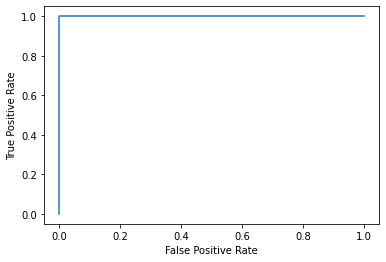

In [9]:
from sklearn.metrics import roc_curve

def graphic_roc(n, alpha, legit_lambda):
    x, y = read_files(n)

    x = flatten(x)
    y = flatten(y)
    predictions = []

    for x_i in x:
        prediction = predict(x, y, x_i, [legit_lambda, 1], alpha)
        predictions.append(prediction)

    FPR, TPR, _ = roc_curve(y, predictions)
    plt.plot(FPR, TPR)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


graphic_roc(n, alpha, 1)

### График зависимости точности от параметра λlegit

In [23]:
def graphic_lambda(n, alpha, legit_lambda, steps):
    data, length = get_data_for_cross(n)

    accuracy_list = []
    lambda_list = []
    for i in range(steps):
        cur_lambda = 10 ** (legit_lambda * i / (steps - 1))
        accuracy, legit_wrong_count = cross_validation(data, alpha, cur_lambda)

        print('lambda:', cur_lambda, ',\taccuracy:', accuracy, ',\twrong legit:', legit_wrong_count)
        accuracy_list.append(math.log(accuracy))
        lambda_list.append(cur_lambda)
    plt.plot(lambda_list, accuracy_list, label='accuracy')
    plt.xlabel('Legit lambda')
    plt.ylabel('Accuracy')
    plt.show()

    return accuracy_list, lambda_list

lambda: 1.0 ,	accuracy: 0.9761467889908259 ,	wrong legit: 9
lambda: 59948425.03189409 ,	accuracy: 0.9743119266055047 ,	wrong legit: 4
lambda: 3593813663804625.5 ,	accuracy: 0.963302752293578 ,	wrong legit: 2
lambda: 2.1544346900318777e+23 ,	accuracy: 0.9467889908256881 ,	wrong legit: 2
lambda: 1.2915496650148827e+31 ,	accuracy: 0.9366972477064219 ,	wrong legit: 2
lambda: 7.742636826811215e+38 ,	accuracy: 0.9192660550458716 ,	wrong legit: 1
lambda: 4.641588833612753e+46 ,	accuracy: 0.9027522935779817 ,	wrong legit: 1
lambda: 2.7825594022071144e+54 ,	accuracy: 0.8908256880733945 ,	wrong legit: 1
lambda: 1.6681005372000556e+62 ,	accuracy: 0.863302752293578 ,	wrong legit: 1
lambda: 1e+70 ,	accuracy: 0.8440366972477065 ,	wrong legit: 0


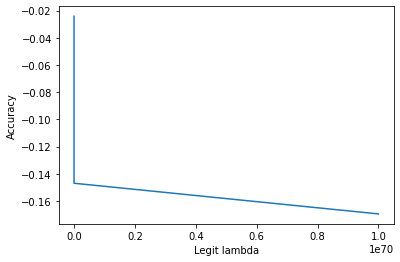

([-0.02414230532159952,
  -0.02602377342130513,
  -0.03738753207162033,
  -0.054679029181681285,
  -0.06539515705852392,
  -0.08417969357837927,
  -0.1023070781709359,
  -0.11560650693186451,
  -0.14698983563780973,
  -0.16955930518010334],
 [1.0,
  59948425.03189409,
  3593813663804625.5,
  2.1544346900318777e+23,
  1.2915496650148827e+31,
  7.742636826811215e+38,
  4.641588833612753e+46,
  2.7825594022071144e+54,
  1.6681005372000556e+62,
  1e+70])

In [24]:
graphic_lambda(1, alpha, 70, 10)

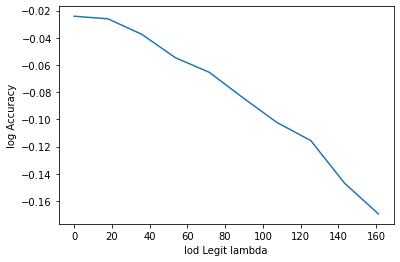

In [26]:
accuracy_list = [-0.02414230532159952,
  -0.02602377342130513,
  -0.03738753207162033,
  -0.054679029181681285,
  -0.06539515705852392,
  -0.08417969357837927,
  -0.1023070781709359,
  -0.11560650693186451,
  -0.14698983563780973,
  -0.16955930518010334]

lambda_list = [1.0,
  59948425.03189409,
  3593813663804625.5,
  2.1544346900318777e+23,
  1.2915496650148827e+31,
  7.742636826811215e+38,
  4.641588833612753e+46,
  2.7825594022071144e+54,
  1.6681005372000556e+62,
  1e+70]

log_lambda_list = list(math.log(i) for i in lambda_list)


plt.plot(log_lambda_list, accuracy_list, label='accuracy')
plt.xlabel('lod Legit lambda')
plt.ylabel('log Accuracy')
plt.show()